In [1]:
#Array packages
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy

import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\1_Streamflow")
print(os.getcwd())

c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\1_Streamflow


In [1]:
#testing git

### 1. Modify the stating and ending date (Initially it is based on level, change it to streamflow)

In [202]:
gauge_info=pd.read_csv(r"3_Data\Data_r\2_Station\metadata.csv")
gauge_info.drop(columns=['Level_Entries'],inplace=True)


for g in range(len(gauge_info)):
    data1=pd.read_csv(f'3_Data/Data_r/2_Station/streamflow/{gauge_info.iloc[g,0]}.csv',index_col=0,parse_dates=True)        
    data1.drop(columns=['Level (m)'],inplace=True)
    data1=data1[data1['Streamflow (cumecs)'].notna()]

    if(len(data1)!=0):
        gauge_info.loc[g,['Start_date']]=data1.index[0]
        gauge_info.loc[g,['End_date']]=data1.index[-1]
        gauge_info.loc[g,['Expected_entries']]=len(pd.date_range(data1.index[0],data1.index[-1]))
    else:
        gauge_info.loc[g,['Start_date']]=0
        gauge_info.loc[g,['End_date']]=0
        gauge_info.loc[g,['Expected_entries']]=0
    
    data1.to_csv(f'3_Data/Data_p/2_Station/streamflow_data/{gauge_info.iloc[g,0]}.csv')  

## 2. station subsetting
 1. Identify the stations with minimum 30 years of data
 2. Subset the station with minimum 30 years of data and with period upto 2010
 3. Percentage of missing data

In [203]:

for i in range(len(gauge_info.index)):
    gauge_info.loc[i,'Period_length']=pd.to_datetime(gauge_info.loc[i,'End_date']).year-pd.to_datetime(gauge_info.loc[i,'Start_date']).year


gauge_info_p=gauge_info.loc[(gauge_info['Period_length']>28) & (pd.to_datetime(gauge_info['End_date'])>'2010') & ((gauge_info['Streamflow_Entries']/gauge_info['Expected_entries'])>0.7) ,:]

gauge_info_p=gauge_info_p.reset_index(drop=True)
gauge_info_p.drop(columns='Privacy',inplace=True) 
    
gauge_info_p.to_csv(f'3_Data/Data_p/2_Station/gauge_info_p.csv')

# Minimum data and maximum data
pd.to_datetime(gauge_info_p['End_date']).max()
pd.to_datetime(gauge_info_p['Start_date']).min()



Timestamp('1959-05-01 00:00:00')

## 3. Create streamflow data over different stations into single xarrayy (station and time)
The main aim is to make a consistent single xarray for better management

In [2]:
gauge_info_p=pd.read_csv(f'3_Data/Data_p/2_Station/gauge_info_p.csv',index_col=0)
date1=pd.date_range(start='1970',end='2021',freq='D')
station=list(gauge_info_p['Station'])
gauge_final=pd.DataFrame(index=date1, columns=station)

for g in range(len(gauge_info_p.index)):
    gauge_id=pd.read_csv(f'3_Data/Data_p/2_Station/streamflow_data/{gauge_info_p.iloc[g,0]}.csv',index_col=0,parse_dates=True)
    common_date=np.intersect1d(gauge_id.index,date1)
    gauge_final.loc[common_date,gauge_info_p.iloc[g,1]]=gauge_id.loc[common_date, 'Streamflow (cumecs)']

gauge_xr=xr.DataArray(np.array(gauge_final),coords=[date1,station],dims=['time','station'],name='streamflow')
gauge_xr = xr.Dataset({'streamflow': gauge_xr })
gauge_xr.to_netcdf(f'3_Data/Data_p/2_Station/Gauge_streamflow.nc')   

In [8]:
## Season
ssn=['All','Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_n=[range(1,13),[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
ds_list=[]
data=xr.open_mfdataset(f'3_Data/Data_p/2_Station/Gauge_streamflow.nc')

for s in tqdm(range(5)):

    sf=data['streamflow'].sel(time=data["time.month"].isin(ssn_n[s])).compute()
    sf=sf.expand_dims(season=[ssn[s]])
    ds_list.append(sf)
    
sf_ssn=xr.concat(ds_list,dim='season')
sf_ssn_ds = xr.Dataset({'streamflow': sf_ssn})
sf_ssn_ds.to_netcdf(f'3_Data/Data_p/2_Station/Gauge_streamflow_ssn.nc')  

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 14.53it/s]


In [3]:
###### Calculate Indices######

ssn=['All','Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_n=[range(1,13),[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
ds_drt=[];ds_fld=[]
data=xr.open_mfdataset(f'3_Data/Data_p/2_Station/Gauge_streamflow.nc')


for s in tqdm(range(5)):

    ## drt
    drt_ssn=data['streamflow'].sel(time=data["time.month"].isin(ssn_n[s])).rolling(time=7).mean().resample(time='YE').min()
    drt_ssn=drt_ssn.expand_dims(season=[ssn[s]])
    ds_drt.append(drt_ssn)

    ## Flood
    fld_ssn=data['streamflow'].sel(time=data["time.month"].isin(ssn_n[s])).resample(time='YE').quantile(0.95, dim='time')
    fld_ssn=fld_ssn.expand_dims(season=[ssn[s]])
    ds_fld.append(fld_ssn)

    
drt=xr.concat(ds_drt,dim='season')
fld=xr.concat(ds_fld,dim='season').drop(['quantile'])

dry_wet_ssn = xr.Dataset({'drt_flow': drt, 'fld_flow': fld})
dry_wet_ssn.to_netcdf(r'3_Data/Data_p/2_Station/Gauge_indices.nc')



100%|██████████| 5/5 [00:05<00:00,  1.03s/it]
C:\Users\sstar\AppData\Local\Temp\ipykernel_17788\3122266122.py:22: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  fld=xr.concat(ds_fld,dim='season').drop(['quantile'])
c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\array\reductions.py:540: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


## 1. Station visualizaation

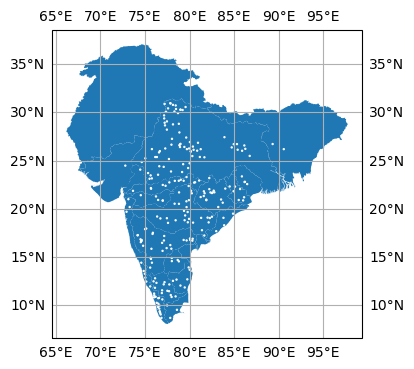

In [195]:
gauge_info=pd.read_csv(r"3_Data\Data_r\2_Station\metadata.csv")
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

fig, ax1 = plt.subplots(1, 1, figsize=(4,4), subplot_kw={"projection": ccrs.PlateCarree()})
south_asia.plot(ax=ax1,transform=ccrs.PlateCarree())

c1=np.repeat(['white'],len(gauge_info_p['Latitude']))
ax1.scatter(gauge_info_p['Longitude'],gauge_info_p['Latitude'],c=c1,s=0.5)
# Add gridlines and titles for better readability
ax1.gridlines(draw_labels=True)